**Don't run the code in the next cell this code if you are following the notebook!**
The purpose of this is to avoid long warning messages corrupting the slide display during presentation.

In [2]:
import numpy
numpy.seterr(all='ignore')
import iris
iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True
import warnings
warnings.simplefilter('ignore')

/opt/tljh/user/lib/python3.7/site-packages/iris/__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
/opt/tljh/user/lib/python3.7/site-packages/iris/__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_no_unlimited' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


# Analysis of large data sets: Geo-Python

## An introduction to Iris

### What is Iris?

* Iris is a Python library to make working with meteorological, oceanographic and climate data easier
* A community software package, led by a team at the Met Office with external contributors
* It has been evolving over the last 4 or 5 years and is now at version 1.10
* Lots of ongoing development and there is good support available

### Why use Iris?

 * It keeps all of your arrays together in one place - the data, the coordinates etc.
 * It takes care of metadata - less chance of making a mistake
 * It takes care of the layout of your data (which dimensions are which)
 * Can load data from a variety of formats including NetCDF, PP and GRIB
 * Convenient plotting functionality

## Iris and the cube

The top level object in Iris is called a cube. A cube contains data and metadata about a single phenomenon and is an implementation of the data model interpreted from the *Climate and Forecast (CF) Metadata Conventions*.

Each cube has:

 * A data array (typically a NumPy array).
 * A "name", preferably a CF "standard name" to describe the phenomenon that the cube represents.
 * A collection of coordinates to describe each of the dimensions of the data array. These coordinates are split into two types:
    * Dimensioned coordinates are numeric, monotonic and represent a single dimension of the data array. There may be only one dimensioned coordinate per data dimension.
    * Auxilliary coordinates can be of any type, including discrete values such as strings, and may represent more than one data dimension.

A more complete explanation is available in the [Iris user guide](http://scitools.org.uk/iris/docs/latest/userguide/iris_cubes.html).

Let's take a simple example to demonstrate the cube concept.

Suppose we have a ``(3, 2, 4)`` NumPy array:

![](../images/multi_array.png)


Where dimensions 0, 1, and 2 have lengths 3, 2 and 4 respectively.

The Iris cube to represent this data may consist of:

 * a standard name of "air_temperature" and units of "kelvin"

 * a data array of shape ``(3, 2, 4)``

 * a coordinate, mapping to dimension 0, consisting of:
     * a standard name of "height" and units of "meters"
     * an array of length 3 representing the 3 height points
     
 * a coordinate, mapping to dimension 1, consisting of:
     * a standard name of "latitude" and units of "degrees"
     * an array of length 2 representing the 2 latitude points
     * a coordinate system such that the latitude points could be fully located on the globe
     
 * a coordinate, mapping to dimension 2, consisting of:
     * a standard name of "longitude" and units of "degrees"
     * an array of length 4 representing the 4 longitude points
     * a coordinate system such that the longitude points could be fully located on the globe

Pictorially the cube has taken on more information than a simple array:

![](../images/multi_array_to_cube.png)

## Working with a cube

In [1]:
import iris
import numpy as np

In [2]:
print(iris.__version__)
print(np.__version__)

2.4.0
1.19.1


Whilst it is possible to construct a cube by hand, a far more common approach to getting hold of a cube is to use the Iris load function to access data that already exists in a file.

In [3]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
print(cubes)

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
1: surface_altitude / (m)              (grid_latitude: 204; grid_longitude: 187)


We can see that we've loaded two cubes, one representing the "surface_altitude" and the other representing "air_potential_temperature". We can infer even more detail from this printout; for example, what are the dimensions and shape of the "air_potential_temperature" cube?

Above we've printed the ``iris.cube.CubeList`` instance representing all of the cubes found in the given filename. However, we can see more detail by printing individual cubes:

In [4]:
air_pot_temp = cubes[0]
print(air_pot_temp)

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

## Parts of a Cube

In [5]:
cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
print(cube)

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)


To access a cube's data array the ``data`` property exists. This is either a NumPy array or in some cases a NumPy masked array. 

It is important to note that for most of the supported filetypes in Iris, the cube's data isn't actually loaded until you request it via this property (either directly or indirectly). After you've accessed the data once, it is stored on the cube and thus won't be loaded from disk again.

To find the shape of a cube's data it is possible to call ``cube.data.shape`` or ``cube.data.ndim``, but this will trigger any unloaded data to be loaded. Therefore ``shape`` and ``ndim`` are properties available directly on the cube that do not unnecessarily load data.

In [6]:
print(cube.shape)
print(cube.ndim)
print(type(cube.data))

(240, 37, 49)
3
<class 'numpy.ma.core.MaskedArray'>


The ``standard_name``, ``long_name`` and to an extent ``var_name`` are all attributes to describe the phenomenon that the cube represents. The ``name()`` method is a convenience that returns the first non-empty attributes in the order they are listed above. 

In [8]:
print(cube.standard_name)
print(cube.long_name)
print(cube.var_name)
print(cube.name())

air_temperature
None
air_temperature
air_temperature


To rename a cube, it is possible to set the attributes manually, but it is generally easier to use the ``rename()`` method.

In [9]:
cube.rename("A name that isn't a valid CF standard name")

In [10]:
print(cube.standard_name)
print(cube.long_name)
print(cube.var_name)
print(cube.name())

None
A name that isn't a valid CF standard name
None
A name that isn't a valid CF standard name


The ``units`` attribute on a cube tells us the units of the numbers held in the data array. We can manually change the units, or better, we can convert the cube to another unit using the ``convert_units`` method, which will automatically update the data array.

In [14]:
print(cube.data.max(), cube.units)
cube.convert_units('Celsius')
print(cube.data.max(), cube.units)

32.9233 Celsius
32.9233 Celsius


A cube has a dictionary for extra general purpose attributes, which can be accessed with the ``cube.attributes`` attribute:

In [15]:
print(cube.attributes)
print(cube.attributes['STASH'])

{'Conventions': 'CF-1.5', 'STASH': STASH(model=1, section=3, item=236), 'Model scenario': 'A1B', 'source': 'Data from Met Office Unified Model 6.05'}
m01s03i236


## Coordinates

As we've seen, cubes need coordinate information to help us describe the underlying phenomenon. Typically a cube's coordinates are accessed with the ``coords`` or ``coord`` methods. The latter *must* return exactly one coordinate for the given parameter filters, where the former returns a list of matching coordinates, possibly of length 0.

For example, to access the time coordinate, and print the first 3 times:

In [16]:
time = cube.coord('time')
print(time[:3])

DimCoord([1860-06-01 00:00:00, 1861-06-01 00:00:00, 1862-06-01 00:00:00], bounds=[[1859-12-01 00:00:00, 1860-12-01 00:00:00],
       [1860-12-01 00:00:00, 1861-12-01 00:00:00],
       [1861-12-01 00:00:00, 1862-12-01 00:00:00]], standard_name='time', calendar='360_day', var_name='time')


The coordinate interface is very similar to that of a cube. The attributes that exist on both cubes and coordinates are: ``standard_name``, ``long_name``, ``var_name``, ``units``, ``attributes`` and ``shape``. Similarly, the ``name()``, ``rename()`` and ``convert_units()`` methods also exist on a coordinate.

A coordinate does not have ``data``, instead it has ``points`` and ``bounds`` (``bounds`` may be ``None``). In Iris, time coordinates are currently represented as "a number since an epoch":

In [17]:
print(repr(time.units))
print(time.points[:3])
print(time.bounds[:3])

Unit('hours since 1970-01-01 00:00:00', calendar='360_day')
[-946800. -938160. -929520.]
[[-951120. -942480.]
 [-942480. -933840.]
 [-933840. -925200.]]


These numbers can be converted to datetime objects with the unit's ``num2date`` method. Dates can be converted back again with the ``date2num`` method:

In [18]:
import datetime

print(time.units.num2date(time.points[:3]))
print(time.units.date2num(datetime.datetime(1970, 2, 1)))

[cftime.Datetime360Day(1860, 6, 1, 0, 0, 0, 0)
 cftime.Datetime360Day(1861, 6, 1, 0, 0, 0, 0)
 cftime.Datetime360Day(1862, 6, 1, 0, 0, 0, 0)]
720.0


Another important attribute on a coordinate is its coordinate system. Coordinate systems may be ``None`` for trivial coordinates, but particularly for spatial coordinates, they may be complex definitions of things such as the projection, ellipse and/or datum.

In [19]:
lat = cube.coord('latitude')
print(lat.coord_system)

GeogCS(6371229.0)


In this case, the latitude's coordinate system is a simple geographic latitude on a spherical globe of radius 6371229 (meters).

Sometimes it is desirable to add bounds to a coordinate that doesn't have any. 

The ``guess_bounds`` method on a coordinate is useful in this regard. 

For example, the latitude coordinate previously obtained does not have bounds, but we can either set some manually, or use the ``guess_bounds`` method:

In [20]:
print(lat.points[:3])
print(lat.bounds)
if lat.bounds is None:
    lat.guess_bounds()
print(lat.bounds[:3])

[15.   16.25 17.5 ]
None
[[14.375 15.625]
 [15.625 16.875]
 [16.875 18.125]]


### Exercise 1

1\. Using the file in ``iris.sample_data_path('atlantic_profiles.nc')`` load the data and print the cube list. Store these cubes in a variable called cubes.

In [22]:
fname=iris.sample_data_path('atlantic_profiles.nc')
cubes = iris.load(fname)
print(cubes)

0: sea_water_potential_temperature / (K) (depth: 40; latitude: 6; longitude: 8)
1: sea_water_practical_salinity / (1e-3) (depth: 40; latitude: 6; longitude: 8)


2\. Loop through each of the cubes (e.g. ``for cube in cubes``) and print the standard name of each.

In [23]:
for cube in cubes: 
    print(cube.standard_name)

sea_water_potential_temperature
sea_water_practical_salinity


3\. Extract the "sea_water_potential_temperature" cube. Print the minimum, maximum, mean and standard deviation of the cube's data.

In [39]:
cube=cubes[0]
cube.data.std()

8.186847346401617

## 4\. Print the attributes of the cube.

In [25]:
cube.attributes

{'Conventions': 'CF-1.5'}

5\. Print the names of all coordinates on the cube. (Hint: Remember the cube.coords method without any keywords will give us all of the cube's coordinates)

In [28]:
cube.coords

<bound method Cube.coords of <iris 'Cube' of sea_water_potential_temperature / (K) (depth: 40; latitude: 6; longitude: 8)>>

6\. Get hold of the "latitude" coordinate on the cube. Identify whether this coordinate has bounds. Print the minimum and maximum latitude points in the cube.

In [42]:
lat=cube.coord('latitude')
print(lat.points.min())

-9.833798


## Loading data into Iris

We've already seen the basic ``load`` function, but we can also control which cubes are actually loaded with *constraints*. The simplest constraint is just a string, which filters cubes based on their name:

In [43]:
fname = iris.sample_data_path('uk_hires.pp')
print(iris.load(fname, 'air_potential_temperature'))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


### Loading data from multiple files

You can load multiple files at the same time by providing a list of file names:

In [45]:
filename1 = iris.sample_data_path('GloSea4', 'ensemble_010.pp')
filename2 = iris.sample_data_path('GloSea4', 'ensemble_011.pp')
cubes = iris.load([filename1, filename2])
print(cubes)

0: surface_temperature / (K)           (realization: 2; time: 6; latitude: 145; longitude: 192)


#### Note on sample_data_path:

Throughout this course we will make use of the sample data that Iris provides. The function ``iris.sample_data_path`` returns the appropriate path to the file in the Iris sample data collection. A common mistake for Iris users is to use the ``sample_data_path`` function to access data that is not part of Iris's sample data collection - this is bad practice and is unlikely to work in the future.

### The three load functions: load, load_cube and load_cubes

There are three main load functions in Iris: ``load``, ``load_cube`` and ``load_cubes``.

1. **load** is a general purpose loading function. Typically this is where all data analysis will start, before more loading is refined with the more controlled loading from the other two functions.
2. **load_cube** returns a single cube from the given source(s) and constraint. There will be exactly one cube, or an exception will be raised.
3. **load_cubes** returns a list of cubes from the given sources(s) and constraint(s). There will be exactly one cube per constraint, or an exception will be raised.

In general, it is a good idea to make use of the ``load_cube``/``load_cubes`` functions rather than the generic ``load`` function in non-exploratory code. Doing so makes your code more resilient to changes in the data source, often results in more readable/maintainable code, and in combination with well defined constraints, often leads to improve load performance.

The load functions all accept either a single filename or a list of filenames to load, and any of the filenames can be "glob" patterns (http://docs.python.org/2/library/glob.html).

## Saving cubes

The ``iris.save`` function provides a convenient interface to save Cube and CubeList instances.

To save some cubes to a NetCDF file:

In [47]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
iris.save(cubes, 'saved_cubes.nc')

Extra keywords can be passed to specific fileformat savers.

In [48]:
!ncdump -h saved_cubes.nc | head -n 20
!rm saved_cubes.nc

netcdf saved_cubes {
dimensions:
	time = 3 ;
	model_level_number = 7 ;
	grid_latitude = 204 ;
	grid_longitude = 187 ;
	bnds = 2 ;
variables:
	float air_potential_temperature(time, model_level_number, grid_latitude, grid_longitude) ;
		air_potential_temperature:standard_name = "air_potential_temperature" ;
		air_potential_temperature:units = "K" ;
		air_potential_temperature:um_stash_source = "m01s00i004" ;
		air_potential_temperature:grid_mapping = "rotated_latitude_longitude" ;
		air_potential_temperature:coordinates = "forecast_period forecast_reference_time level_height sigma surface_altitude" ;
	int rotated_latitude_longitude ;
		rotated_latitude_longitude:grid_mapping_name = "rotated_latitude_longitude" ;
		rotated_latitude_longitude:longitude_of_prime_meridian = 0. ;
		rotated_latitude_longitude:earth_radius = 6371229. ;
		rotated_latitude_longitude:grid_north_pole_latitude = 37.5 ;
		rotated_latitude_longitude:grid_north_pole_longitude = 177.5 ;


## Selecting parts of a cube

### Indexing

Cubes can be indexed in a familiar manner to that of NumPy arrays:

In [49]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname, 'air_potential_temperature')
print(cube.summary(shorten=True))

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


In [50]:
subcube = cube[..., 15:35, :10]
print(subcube.summary(shorten=True))

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 20; grid_longitude: 10)


Note: the result of indexing a cube is *always* a copy and never a *view* on the original data.

### Constraints

Iris's constraints mechanism provides a powerful way to filter a subset of data from a larger collection. We've already seen that constraints can be used at load time to return data of interest from a file, but we can also apply constraints to a single cube, or a list of cubes, using their respective ``extract`` methods:



In [51]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
print(cubes.extract('air_potential_temperature'))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


The simplest constraint, namely a string that matches a cube's name, is conveniently converted into an actual ``iris.Constraint`` instance wherever needed. However, we could construct this constraint manually and compare with the previous result:

In [52]:
pot_temp_constraint = iris.Constraint('air_potential_temperature')
print(cubes.extract(pot_temp_constraint))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


The Constraint constructor also takes arbitrary keywords to constrain coordinate values. For example, to extract model level number 10 from the air potential temperature cube:

In [53]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname, 'air_potential_temperature')

In [54]:
level_constraint = iris.Constraint(model_level_number=10)
cube_l10 = cube.extract(level_constraint)
print(cube_l10.summary(shorten=True))
print(cube_l10.coord('model_level_number'))

air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
DimCoord(array([10], dtype=int32), standard_name='model_level_number', units=Unit('1'), attributes={'positive': 'up'})


We could also use a list of possible values instead of a single value in our constraint:

In [55]:
level_constraint = iris.Constraint(model_level_number=[4, 10])
print(cube.extract(level_constraint))

air_potential_temperature / (K)     (time: 3; model_level_number: 2; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

Constraints can also be defined by arbitrary functions that operate on each cell of a coordinate. The function should return `True` if we want to keep the input cell, and `False` otherwise:

In [56]:
def less_than_10(cell):
    """Return True for values that are less than 10."""
    return cell < 10

level_constraint = iris.Constraint(model_level_number=less_than_10)
print(cube.extract(level_constraint))

air_potential_temperature / (K)     (time: 3; model_level_number: 3; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

## Collapsing and aggregation

We often want to apply some reduction to our data using a statistical operator.
Iris provides a couple of useful ways to do this that preserve metadata.

In [57]:
cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
print(cube)

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)


We'll start by taking the mean over the time dimension of our cube. We use the **`collapsed()`** method, giving it the name of the coordinate we want to collapse and an aggregator that tells it how to collapse the coordinate:

In [58]:
import iris.analysis

print(cube.collapsed('time', iris.analysis.MEAN))

air_temperature / (K)               (latitude: 37; longitude: 49)
     Dimension coordinates:
          latitude                           x              -
          longitude                          -              x
     Scalar coordinates:
          forecast_period: 1043274 hours, bound=(10794, 2075754) hours
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
          time: 1979-12-01 00:00:00, bound=(1859-12-01 00:00:00, 2099-12-01 00:00:00)
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)
          mean: time


/opt/tljh/user/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


We can use a variety of built-in aggregators to compute different quantities, for example we could also compute the standard deviation over the time dimension:

In [59]:
print(cube.collapsed('time', iris.analysis.STD_DEV))

air_temperature / (K)               (latitude: 37; longitude: 49)
     Dimension coordinates:
          latitude                           x              -
          longitude                          -              x
     Scalar coordinates:
          forecast_period: 1043274 hours, bound=(10794, 2075754) hours
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
          time: 1979-12-01 00:00:00, bound=(1859-12-01 00:00:00, 2099-12-01 00:00:00)
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)
          standard_deviation: time


/opt/tljh/user/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


It is possible to collapse a cube over multiple dimensions, in this case we compute the global mean air temperature by collapsing over the latitude and longitude dimensions:

In [60]:
global_mean = cube.collapsed(['latitude', 'longitude'],
                             iris.analysis.MEAN)
print(global_mean)
print(global_mean.data[0])

air_temperature / (K)               (time: 240)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
          latitude: 37.5 degrees, bound=(15.0, 60.0) degrees
          longitude: 270.0 degrees, bound=(225.0, 315.0) degrees
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)
          mean: latitude, longitude
284.5098


/opt/tljh/user/lib/python3.7/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/tljh/user/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/tljh/user/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


Notice the warning in the previous example. We averaged over space but did not take into account the variation in grid cell area over the globe. To do this averaging correctly we need weights. Iris has built-in functionality for computing area weights (but requires bounded grid coordinates):

In [61]:
from iris.analysis.cartography import area_weights

cube.coord('latitude').guess_bounds()
cube.coord('longitude').guess_bounds()
cell_weights = area_weights(cube)

global_mean = cube.collapsed(['latitude', 'longitude'],
                             iris.analysis.MEAN,
                             weights=cell_weights)
print(global_mean)
print(global_mean.data[0])

air_temperature / (K)               (time: 240)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
          latitude: 37.5 degrees, bound=(14.375, 60.625) degrees
          longitude: 270.0 degrees, bound=(224.0625, 315.9375) degrees
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)
          mean: latitude, longitude
286.48658708791567


## Creating extra annotation coordinates for statistical convenience

Sometimes we want to be able to categorise data before performing statistical operations on it. For example, we might want to categorise our data by "daylight maximum" or "seasonal mean" etc. Both of these categorisations would be based on the time coordinate.

The ``iris.coord_categorisation`` module provides convenience functions to add some common categorical coordinates, and provides a generalised function to allow each creation of custom categorisations. 

In [62]:
import iris.coord_categorisation as coord_cat

filename = iris.sample_data_path('ostia_monthly.nc')
cube = iris.load_cube(filename, 'surface_temperature')

The cube loaded represents the monthly air_temperature from April 2006 through to October 2010. Let's add a categorisation coordinate to this cube to identify the climatological season (i.e "djf", "mam", "jja" or "son") of each time point:

In [63]:
coord_cat.add_season(cube, 'time', name='clim_season')
print(cube.coord('clim_season'))

AuxCoord(array(['mam', 'mam', 'jja', 'jja', 'jja', 'son', 'son', 'son', 'djf',
       'djf', 'djf', 'mam', 'mam', 'mam', 'jja', 'jja', 'jja', 'son',
       'son', 'son', 'djf', 'djf', 'djf', 'mam', 'mam', 'mam', 'jja',
       'jja', 'jja', 'son', 'son', 'son', 'djf', 'djf', 'djf', 'mam',
       'mam', 'mam', 'jja', 'jja', 'jja', 'son', 'son', 'son', 'djf',
       'djf', 'djf', 'mam', 'mam', 'mam', 'jja', 'jja', 'jja', 'son'],
      dtype='<U64'), standard_name=None, units=Unit('no_unit'), long_name='clim_season')


We can now use the cube's ``aggregated_by`` method to "group by and aggregate" on the season, to produce the seasonal mean:

In [64]:
seasonal_mean = cube.aggregated_by('clim_season', iris.analysis.MEAN)
print(seasonal_mean)
print(seasonal_mean.coord('clim_season'))

surface_temperature / (K)           (-- : 4; latitude: 18; longitude: 432)
     Dimension coordinates:
          latitude                      -            x              -
          longitude                     -            -              x
     Auxiliary coordinates:
          clim_season                   x            -              -
          forecast_reference_time       x            -              -
          time                          x            -              -
     Scalar coordinates:
          forecast_period: 0 hours
     Attributes:
          Conventions: CF-1.5
          STASH: m01s00i024
     Cell methods:
          mean: month, year
          mean: clim_season
AuxCoord(array(['mam', 'jja', 'son', 'djf'], dtype='<U64'), standard_name=None, units=Unit('no_unit'), long_name='clim_season')


### Custom categorisation 

You are not limited to the built-in categorisations, you can define any arbitrary categorisation you like and apply it using the **`add_categorised_coord()`** function, but we won't go into detail on that here.

## Cube maths

Basic mathematical operators exist on the cube to allow one to add, subtract, divide, multiply and perform other mathematical operations on cubes of a similar shape to one another:

In [65]:
a1b = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
e1 = iris.load_cube(iris.sample_data_path('E1_north_america.nc'))

print(e1.summary(True))
print(a1b.summary(True))

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)


In [66]:
scenario_difference = a1b - e1
print(scenario_difference)

unknown / (K)                       (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m


Notice that the resultant cube's name is now unknown.

Cube broadcasting is also supported, meaning that the two cubes don't need to have the same shape. This is roughly analagous to broadcasting of NumPy arrays. For example, to compute anomalies with respect to the time-mean:

In [70]:
print(e1 - e1.collapsed('time', iris.analysis.MEAN))

unknown / (K)                       (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m


/opt/tljh/user/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


It is also possible to operate on cubes with numeric scalars, NumPy arrays and even cube coordinates:

In [71]:
e1 * e1.coord('latitude')

<iris 'Cube' of unknown / (0.0174532925199433 K.rad) (time: 240; latitude: 37; longitude: 49)>

Sometimes you'd like to apply an operation that hasn't been pre-defined in Iris, so it is important that we still have the power to update the cube's data directly. Whenever we do this though, we should be mindful of updating the necessary metadata on the cube:

In [72]:
e1_hot = e1.copy()

e1_hot.data = np.ma.masked_less_equal(e1_hot.data, 280)
e1_hot.rename('air temperatures greater than 280K')

## Plotting

Iris has some neat plotting functionality built-in, making use of matplotlib and cartopy and using the metadata provided with cubes to determine coordinates, projections etc.

In [73]:
cube = iris.load_cube(iris.sample_data_path('air_temp.pp'))

We'll use the **`iris.plot`** module to plot this cube:

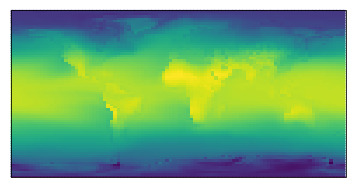

In [76]:
import iris.plot as iplt

iplt.pcolormesh(cube, cmap='viridis')
iplt.show()

As you can see, this plot is a bit basic!

Iris has a second plotting module **`iris.quickplot`** which adds labels and colorbars etc. to plots automatically:

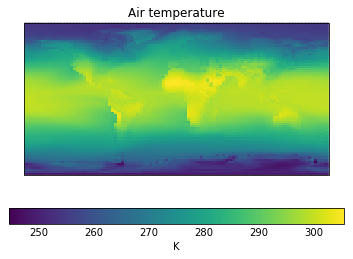

In [77]:
import iris.quickplot as qplt

qplt.pcolormesh(cube, cmap='viridis')
qplt.show()

You can manually create an axes using your desired settings, and pass this to an iris plotting function to tailor your plot:

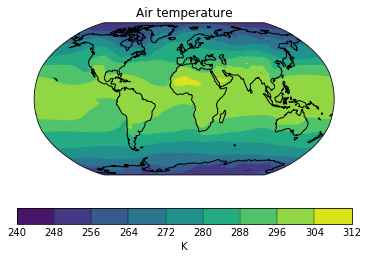

In [79]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()

qplt.contourf(cube, axes=ax, cmap='viridis')
qplt.show()

Several kinds of plots are available, including line plots, scatter plots and 2-d points plots:

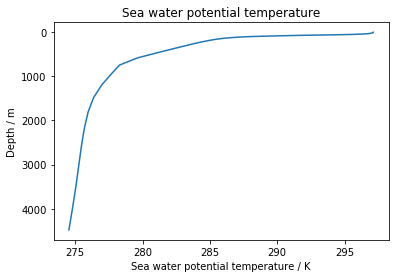

In [80]:
temp = iris.load_cube(iris.sample_data_path('atlantic_profiles.nc'),
                      'sea_water_potential_temperature')

qplt.plot(temp[:, 0, 0], temp.coord('depth'))
qplt.show()

## Regridding

When comparing gridded data sets it is often necessary to perform interpolation/regridding to make different data sets comparable. Iris has a whole suite of interpolation and regridding feautres. Here we'll explore the basic regridding functionality.

First we'll load some data on a global latitude-longitude grid:

In [ ]:
global_air_temp = iris.load_cube(iris.sample_data_path('air_temp.pp'))

In [ ]:
qplt.pcolormesh(global_air_temp, cmap='viridis')
plt.gca().coastlines()
qplt.show()

Next we'll load some data on a rotated pole grid covering the North Atlantic and Europe (Met Office NAE model domain):

In [ ]:
rotated_psl = iris.load_cube(iris.sample_data_path('rotated_pole.nc'))
rotated_psl.convert_units('hPa')

In [ ]:
qplt.pcolormesh(rotated_psl, cmap='viridis')
plt.gca().coastlines()
qplt.show()

If we wanted to compare data on the rotated grid to the global grid, we might regrid the global data onto the smaller rotated pole grid:

In [ ]:
rotated_air_temp = global_air_temp.regrid(rotated_psl,
                                          iris.analysis.Linear())

In [ ]:
qplt.pcolormesh(rotated_air_temp, cmap='viridis')
plt.gca().coastlines()
qplt.show()

Alternatively we might want to put the rotated pole data onto the global latitude-longitude grid. In this direction we must be careful not to extrapolate outside the original domain:

In [ ]:
scheme = iris.analysis.Linear(extrapolation_mode='mask')
global_psl = rotated_psl.regrid(global_air_temp, scheme)

In [ ]:
qplt.pcolormesh(global_psl, cmap='viridis')
plt.gca().coastlines()
qplt.show()

This has only been a short overview of Iris' regridding capabilities. There are more advanced techniques available such as area weighted regridding, and a selection of more generic interpolation routines suited to all kinds of data.

## Exercise 2

This exercise puts together many of the topics covered in this session.

1\. Load the single cube from the file `iris.sample_data_path('SOI_Darwin.nc')`. This contains monthly values of the Southern Oscillation Index.

In [5]:
fname=iris.sample_data_path('SOI_Darwin.nc')
cube=iris.load(fname)

In [8]:
cube=cube[0]

2\. Add two new coordinates based upon the time coordinate, one categorising the meteorological season, and one the year the season was in (hint: add_season and add_season_year are pre-defined). Examine the resulting coordinates.

In [13]:
cube.remove_coord('clim_season')
cube.remove_coord('clim_season_year')
import iris.coord_categorisation as coord_cat
coord_cat.add_season(cube, 'time', name='clim_season')
coord_cat.add_season_year(cube, 'time', name='clim_season_year')

In [16]:
cube.shape

(1776,)

3\. Compute the seasonal means from this cube (i.e. average together the times within in each individual season). You should end up with a time series of length 593 (hint: you can specify two coordinates to aggregate over).

In [22]:
seasonal_mean=cube.aggregated_by(['clim_season_year', 'clim_season'], iris.analysis.MEAN )
seasonal_mean.shape

(593,)

4\. Now compute the seasonal climatology. You should end up with a cube of size 4, one point per season (hint: you can use aggregated_by again).

In [24]:
seasonal_climatology=cube.aggregated_by('clim_season', iris.analysis.MEAN)
seasonal_climatology.shape

(4,)

5\. Extract the DJF season from both the climatology and seasonal means. Use these to compute a time series of DJF anomalies with respect to the DJF mean (hint: remember you can subtract cubes of different dimensionality).

6\. Finally, give the DJF anomalies cube a sensible name and plot the time-series with labelled axes.

## Exercise 3

1\. Load 'A1B_north_america.nc' from the iris sample data

2\. Extract just data from the year 1980 and beyond from the loaded cube

3\. Define a function which takes a coordinate and a single time point as arguments, and returns the decade. For example, your function should return 2010 for the following:

       time = iris.coords.DimCoord([10], 'time', units='days since 2018-01-01')
       print your_decade_function(time, time.points[0])

4\. Add a "decade" coordinate to the loaded cube using your function and the coord categorisation module

5\. Calculate the decadal means cube for this scenario

6\. Create a figure with 3 rows and 4 columns displaying the decadal means, with the decade displayed prominently in each axes' title (hint: the `slices` or `slices_over` method of the cube will be helpful, especially combined with the built-in `enumerate` function in a for-loop)